# GBT spectra dissection:    BINTABLE

This version uses a very basic BINTABLE access using astropy, to show the low level access to SDFITS data. There is some example specutils access at the end, including a simple SDFITS loader.

This should reproduce Example 1 (position switching) from the GBTIDL manual. The datafile **ngc5291.fits** you need is [here](http://safe.nrao.edu/wiki/pub/GB/Data/GBTIDLExampleAndSampleData/ngc5291.fits).

In [1]:
%matplotlib inline

from astropy.io import fits
from astropy import units as u
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from specutils import Spectrum1D, SpectrumList

from astropy.io import ascii
from astropy.nddata import StdDevUncertainty
from astropy.table import Table
from astropy.units import Unit
from astropy.wcs import WCS
from astropy.convolution import convolve, Box1DKernel

from specutils.io import get_loaders_by_extension
from specutils.io.registers import data_loader
from specutils import Spectrum1D

## SDFITS

We begin by dissecting the typical SDFITS file, starting with raw plotting of a spectrum and some basic BINTABLE operations.

The data in a bintable has **rows** and **columns**.   Within GBTIDL a **row** is sometimes also referred to as a **record** and sometimes **#index**.

## First a few useful functions

In [2]:
def my_stats(label,data,edge=0,verbose=True):
    """
    display mean,rms,min,max,npts
    also good for regression
    can optionally take some edges of either side (check)
    """
    if edge > 0:
        mean = data[edge:-edge].mean()
        rms  = data[edge:-edge].std()
        dmin = data[edge:-edge].min()
        dmax = data[edge:-edge].max()
    else:
        mean = data.mean()
        rms  = data.std()
        dmin = data.min()
        dmax = data.max()
    if verbose:
        print("%s  %s %s %s %s %d" %  (label,repr(mean),repr(rms),repr(dmin),repr(dmax),len(data)-2*edge))
    return (mean,rms,dmin,dmax,len(data)-2*edge)

In [3]:
def dcmeantsys(calon,caloff,tcal,mode=0, fedge=10, nedge=None):
    """
    following the GBTIDL routine with same name, get the tsys from 
    the neighboring calon and caloff we define an extra way to set 
    the edge size, nedge, if you prefer to use number of edge channels
    instead of the inverse fraction
    
    mode=0     do the mean before the division
    mode=1     do the mean after the division
    """
    nchan = len(calon)
    if nedge == None:
        nedge = nchan // fedge     # 10 %
    if mode == 0:
        meanoff = np.mean(caloff[nedge:-nedge])
        meandiff = np.mean(calon[nedge:-nedge] - caloff[nedge:-nedge])
        meanTsys = ( meanoff / meandiff * tcal + tcal/2.0 )
    else:
        meanTsys = np.mean( caloff[nedge:-nedge] / (calon[nedge:-nedge] - caloff[nedge:-nedge]) )
        meanTsys = meanTsys * tcal + tcal/2.0
    return meanTsys

In [4]:
def my_worker1(data,tcal, mode=0):
    """ 
    an example of a tsys calculator (not used in this way, see dcmeantsys)
    mode=0      the calon is first
    mode=1      the caloff is first
    """
    (nrow,nchan) = data.shape
    print(data.shape, tcal.shape)
    nrow2 = nrow//2
    data2 = np.zeros(nrow2*nchan).reshape(nrow2, nchan)
    if mode==0:
        ion = 0
        ioff = 1
    else:
        ion = 1
        ioff = 0
    for row in range(0,nrow,2):
        calon  = data[row + ion]  
        caloff = data[row + ioff]
        data2[row//2] = tcal[row]*caloff/(calon-caloff) + tcal[row]/2.0
    return data2

# spectra2 = my_worker1(spectra, tcal)

In [5]:
def my_worker2(data,tcal,nint=11,nscan=4,mode=0):
    """ 
    an example of a PS style sequence of on/off:
    it takes 4 phases to create an integration
    The nint=11 should NOT be changed, this is for example1
    The nscan=4 can be changed to 2 and 1 if you want to test 
    fewer data scans
    Data dimension:  DATA(cal=2, int=11, pol=2, proc=2, scan=4)
    for NGC5291
    
    mode : experimenting trying to understand GBTIDL
           mode=0    Teuben method (seemed more logical to me)
           mode=1    Braatz method (as GBTIDL used)
    """
    (nrow,nchan) = data.shape
    # reduction by 4:     2 from calon/caloff    2 from procseqn ON/OFF
    nrow4 = nrow * nscan // 4 // 4
    data4 = np.zeros(nrow4*nchan).reshape(nrow4, nchan)
    tsys4 = np.zeros(nrow4)
    i=0
    for iscan in range(nscan):
        for iint in range(nint*2):
            i1 = iscan*nint*2*2*2 + iint*2   # sig_calon    "ON"
            i2 = i1 + 1                      # sig_caloff
            i3 = i1 + 2*nint*2               # ref_calon    "OFF"
            i4 = i3 + 1                      # ref_caloff
            t1 = data[i1]
            t2 = data[i2]
            tsys1 = dcmeantsys(t1,t2,tcal[i1])
            t3 = data[i3]
            t4 = data[i4]
            tsys2 = dcmeantsys(t3,t4,tcal[i3])
            #print(i,i1,i3,tsys1,tsys2)
            #    review this math, i'm not getting the exact GBTIDL numbers out
            tsys = tsys2
            ta = tsys * (t1-t3)/t3
            tb = tsys * (t2-t4)/t4
            t5 = 0.5*(t1+t2)        # sig, this is the Braatz2009 method
            t6 = 0.5*(t3+t4)        # ref
            if mode==0:
                data4[i] = 0.5*(ta+tb)
            elif mode==1:
                data4[i] = tsys*(t5-t6)/t6
            else:
                data4[i] = 0.0 * ta
            tsys4[i] = tsys
            i=i+1
    return (data4,tsys4)

#spectra4 = my_worker2(spectra,tcal)

In [6]:
def my_loader1(fname, src=None, stats=False):
    """
    sample SDFITS loader, for benchmark
    
    fname      File Name
    src        Source name (all if not given)
    """
    hdu     = fits.open(fname)
    header2 = hdu[1].header
    data2   = hdu[1].data
    if src != None:
        wh = data2[:]['OBJECT'] == src
        data2 = data2[wh]
    gbt = {}
    gbt['spectra'] = data2[:]['DATA']
    gbt['tcal']    = data2[:]['TCAL'] 
    gbt['sampler'] = data2[:]['SAMPLER']
    gbt['cal']     = data2[:]['CAL']
    if stats:
        my_stats(fname,gbt['spectra'])
    return gbt

In [7]:
def my_plot(sp, kms=False):
    """ plot a Spectrum1D 
    """
    if kms:
        print("Velocity")
        x = sp.velocity   # doesn't work
    else:
        print("Frequency")
        x = sp.spectral_axis / (1 * Unit("Hz"))/1e6
    if False:
        plt.plot(x, sp.flux)
        if kms:
            plt.xlabel('km/s')
        else:
            plt.xlabel('Frequency [MHz]')
        plt.ylabel('Flux [%s]' % sp.flux.unit)
    else:
        f, ax = plt.subplots()  # doctest: +IGNORE_OUTPUT
        ax.step(sp.spectral_axis, sp.flux) 

## Input parameters

define the SDFITS file name and which row (0 being the first) we want to plot the spectrum of

In [8]:
fname = 'ngc5291.fits'
src   = 'NGC5291' 
row   = 0

Open the FITS file and point to the 2nd HDU, where the BINTABLE is located. No error checking. Data isn't really read yet

In [9]:
%%time
# 20ms: for ex1  fast because data is not really put in memory yet
# 40ms for EDGE
nrow=0
hdu = fits.open(fname)
header2 = hdu[1].header
data2   = hdu[1].data
nrow = len(data2)
print("Found %d rows in %s" % (nrow,fname))

Found 352 rows in ngc5291.fits
CPU times: user 19.2 ms, sys: 0 ns, total: 19.2 ms
Wall time: 18.2 ms


Lets stat all the numbers (nrow * nchan)

In [10]:
%%time
# 790ms for ex1
my_stats(fname,data2[:]['DATA'])

ngc5291.fits  1.077629 0.44048128 0.014442173 72.754105 352
CPU times: user 729 ms, sys: 193 ms, total: 921 ms
Wall time: 510 ms


(1.077629, 0.44048128, 0.014442173, 72.754105, 352)

Grab spectrum by row number. Get some statistics for that row.

In [11]:
%%time 
#  3ms
flux  = data2[row]['DATA']  
nchan = len(flux)
chans = np.arange(nchan)
print("Found %d channels" % nchan)
#
my_stats('STATS for row %d:' % row,flux)

Found 32768 channels
STATS for row 0:  1.1189245 0.33819348 0.03492988 3.7152052 32768
CPU times: user 3.01 ms, sys: 0 ns, total: 3.01 ms
Wall time: 1.95 ms


(1.1189245, 0.33819348, 0.03492988, 3.7152052, 32768)

A super simple plot, channel number vs. flux.

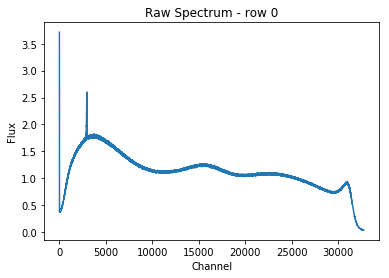

In [12]:
plt.plot(chans,flux)
plt.xlabel("Channel")
plt.ylabel("Flux");
plt.title("Raw Spectrum - row %d" % row);

This is a raw spectrum, mostly showing sky and bandpass.Hidden is a tiny signal, not even visible in the plot, somewhere in the middle around channel 16,000. For this we need to collect an "On" and "Off" spectrum and normalize this difference. And some more magic math. The spike near channel 3000 is galactic. 

This galactic emission is so strong that we can even see it in the raw spectrum. Since it is also extended, an ON/OFF position switching will not properly reconstruct the galactic HI emission. Plotting the ON and OFF from the raw spectra clearly shows this. Cute, but this is not what this notebook is about.

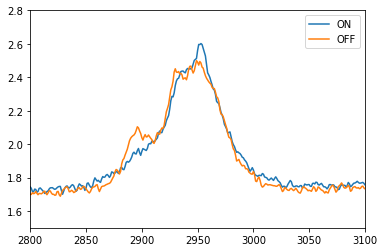

In [13]:
flux_on = data2[0]['DATA'] 
flux_off = data2[44]['DATA']
plt.plot(chans,flux_on,label='ON')
plt.plot(chans,flux_off,label='OFF')
plt.xlim(2800,3100)
plt.ylim(1.5,2.8)
plt.legend();

### Columns and Rows in the BINTABLE

Apart from the 'DATA' column (which is the spectrum), there are lots of meta-data that we will eventually need. Most of these are scalars, so they can be retrieved as vectors of length **nrow**, e.g. the TCAL variable that is crucial for calibration.

In [14]:
%%time 
# 17ms
tcal  = data2[:]['TCAL']  
rec   = np.arange(len(tcal))
print("TCAL mean/rms/min/max/ndata:")
my_stats('TCAL',tcal)

TCAL mean/rms/min/max/ndata:
TCAL  1.4382777 0.013907246 1.4243704 1.452185 352
CPU times: user 10.4 ms, sys: 370 µs, total: 10.8 ms
Wall time: 9.53 ms


(1.4382777, 0.013907246, 1.4243704, 1.452185, 352)

Text(0.5, 1.0, 'TCAL is bimodal (XX and YY)')

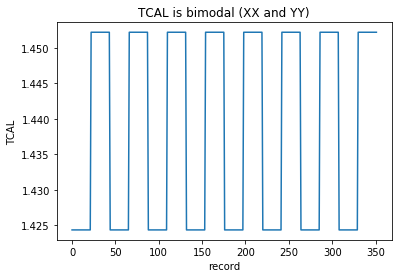

In [15]:
plt.plot(rec,tcal)
plt.xlabel("record")
plt.ylabel("TCAL")
plt.title("TCAL is bimodal (XX and YY)")

Now a simple worker that performs an ON/OFF type operation on all rows. No data is returned, we just want to measure the speed. It will need the **tcal** column from the previous cell. This is not how this data is calibrated, just providing a simple benchmark of the compute speed.

First retrieve a convenient numpy array **spectra[nrow,nchans]** that are the spectra (cf.waterfall plot)

In [16]:
%%time
# 15 ms
spectra = data2[:]['DATA']
print(spectra.shape)

(352, 32768)
CPU times: user 8.23 ms, sys: 29 µs, total: 8.26 ms
Wall time: 8.2 ms


In [17]:
%%time 
whobj = data2[:]['OBJECT'] == src
print('Found %d for %s' % (whobj.sum(),src))

spectra = spectra[whobj]
tcal = data2[whobj]['TCAL']

Found 352 for NGC5291
CPU times: user 463 ms, sys: 276 ms, total: 739 ms
Wall time: 261 ms


Show a waterfall plot for a select number of channels. The N5291 data has 32k channels, and would not look very interesting here. We show that galactic feature here.

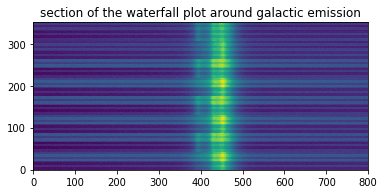

In [18]:
plt.imshow(spectra[:,2500:3300],origin='bottom')
plt.title("section of the waterfall plot around galactic emission");

In [19]:
%%time
#   0.004 empty call
#   185 ms just computing
#   214 ms stuffing it into an array (and returning it)
#   765 ms for EDGE
spectra2 = my_worker1(spectra, tcal)

(352, 32768) (352,)
CPU times: user 25.9 ms, sys: 15.7 ms, total: 41.6 ms
Wall time: 40.6 ms


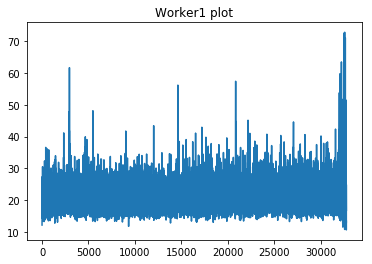

In [20]:
plt.plot(chans,spectra2[row]);
plt.title("Worker1 plot");

###  An example of the ON/OFF calibration

The standard way to calibrate SD data is the ON/OFF style, where you compare two signals ON and OFF the source. This can be in a number of ways though, not just by pointing ON and OFF the source.
$$
     T_A = T_{sys} { {ON-OFF} \over {OFF} }
$$

from GBTIDL's dcmeantsys.pro we can see how the $T_{sys}$ is determined

    ;  mean_tsys = tcal * mean(nocal) / (mean(withcal-nocal)) + tcal/2.0
    
or
$$   
        T_{sys} = T_{cal}  { { <calOFF>} \over {<calON-calOFF>} } + T_{cal}/2
$$
but it is also not uncommon that $T_{sys}$ is specified by the user manually.

First, let's see how/where the data does the ON/OFF by looking at the pointing (RA,DEC) in this example:

ra  206.8520238398091 0.00019655931812051445 206.85188361600473 206.853313987338 352
dec  -30.257011169102068 0.14998292654861403 -30.407041070326546 -30.106962791493608 352
Sources:  ['NGC5291']
ngc5291.fits


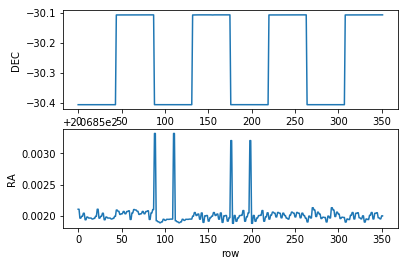

In [21]:
ra = data2[:]['CRVAL2']  
dec = data2[:]['CRVAL3']
rec = range(len(ra))
plt.subplot(2,1,1)
plt.plot(rec,dec)
plt.ylabel('DEC')
plt.subplot(2,1,2)
plt.plot(rec,ra)
plt.ylabel("RA");
plt.xlabel("row")
my_stats('ra',ra)
my_stats('dec',dec)
print('Sources: ',np.unique(data2[:]['OBJECT']))
print(fname)

Hence it is nodding in DEC only. Plus a handfull of deviations in RA, but small (~5", for a 450" beam)

In [22]:
tcal1  = tcal[0]    # the first tcal in PROCSEQN=1, the "ON" position
tcal2  = tcal[44]   # and in 2, the "OFF" position
print(tcal1,tcal2)  # they are the same, these are both XX
print(tcal[22])     # for the YY they are slightly different

1.4243705 1.4243705
1.452185


## We are now going to reproduce the first spectrum. 

By the book.   In GBTIDL we use the **getps** command. The **list** command already told us that the XX polarization was the first few rows, but not until some experimentation did we find out that SAMPLER='A9' was the XX, and 'A13' the YY polarization,and these can also be found using plnum=1 and 0 resp. Perhaps a bit counter-intuitive.  The two **getps** commands in the example below are thus equivalent.

     filein, 'ngc5291.fits'
     getps, 51, intnum=0, sampler='A9', /eqweight
     getps, 51, plnum=1, intnum=0, /eqweight
     ; -> Tsys:  19.30    20.08
     chan
     stats,6000,12000
     ; -> 0.31242     0.14542 -0.28983     0.88213
     write_ascii,'n5291_XX0.tab'
     
The documentation for **getps** does explain that Tsys=19.30 corresponds to the "OFF" and 20.07 to the "ON" position, despite that the "ON" (PROCSEQN=1) comes before the "OFF" (PROCSEQN=2). In fact, PROCSEQN is not listed in the output from **list**. It also mentioned only the "OFF" value of Tsys is used.

     GBTIDL -> list,0,3
     #INDEX       SOURCE       SCAN PROCEDURE POL IFNUM FDNUM        INT SIG CAL
      0          NGC5291         51     OnOff  XX     0     0          0   T   T
      1          NGC5291         51     OnOff  XX     0     0          0   T   F
      2          NGC5291         51     OnOff  XX     0     0          1   T   T
      3          NGC5291         51     OnOff  XX     0     0          1   T   F
     GBTIDL -> list,22,25
     #INDEX       SOURCE       SCAN PROCEDURE POL IFNUM FDNUM        INT SIG CAL
     22          NGC5291         51     OnOff  YY     0     0          0   T   T
     23          NGC5291         51     OnOff  YY     0     0          0   T   F
     24          NGC5291         51     OnOff  YY     0     0          1   T   T
     25          NGC5291         51     OnOff  YY     0     0          1   T   F
     GBTIDL -> list,44,47
     #INDEX       SOURCE       SCAN PROCEDURE POL IFNUM FDNUM        INT SIG CAL
     44          NGC5291         52     OnOff  XX     0     0          0   T   T
     45          NGC5291         52     OnOff  XX     0     0          0   T   F
     46          NGC5291         52     OnOff  XX     0     0          1   T   T
     47          NGC5291         52     OnOff  XX     0     0          1   T   F
  
but in the output of the **summary** command the PROCSEQN is listed in the Seq column
     
     Scan         Source      Vel    Proc Seq    RestF nIF nInt nFd     Az    El
     -------------------------------------------------------------------------------
     51          NGC5291   4386.0   OnOff   1    1.420   1   11   1  198.2  18.8
     52          NGC5291   4386.0   OnOff   2    1.420   1   11   1  198.7  18.9
     53          NGC5291   4386.0   OnOff   1    1.420   1   11   1  199.1  18.5
     54          NGC5291   4386.0   OnOff   2    1.420   1   11   1  199.7  18.6
     55          NGC5291   4386.0   OnOff   1    1.420   1   11   1  200.1  18.2
     56          NGC5291   4386.0   OnOff   2    1.420   1   11   1  200.7  18.3
     57          NGC5291   4386.0   OnOff   1    1.420   1   11   1  202.1  17.5
     58          NGC5291   4386.0   OnOff   2    1.420   1   11   1  202.7  17.6

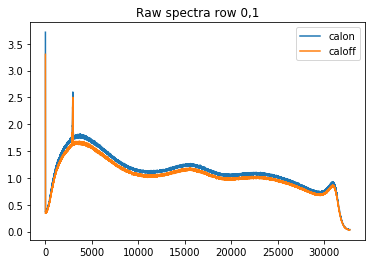

In [23]:
ton1  = spectra[0]
toff1 = spectra[1]
tcal1 = tcal[0] 
plt.plot(chans,ton1,label='calon')
plt.plot(chans,toff1,label='caloff')
plt.legend()
plt.title("Raw spectra row 0,1");

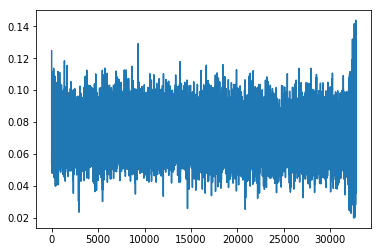

In [24]:
plt.plot(chans,(ton1-toff1)/toff1)

tsys1  20.254757 3.0762427 11.7374735 41.7483 6000


(20.254757, 3.0762427, 11.7374735, 41.7483, 6000)

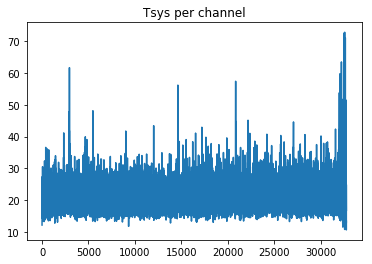

In [25]:
tsys1v = tcal1 * toff1 / (ton1 - toff1) + tcal1/2.0
plt.plot(chans,tsys1v)
plt.title("Tsys per channel")
my_stats('tsys1',tsys1v[6000:12000])

Using **tsys** as a spectrum will not work. Too noisy. In fact, in GBTIDL there is a special averaging style that computes the mean **tsys** by discarding 10% of the edges and taking the ratio of the mean of those. See the **dcmeantsys** function.


tsys from ON: 20.075016379356384
mode=0,1 should give 20.08 and 20.61


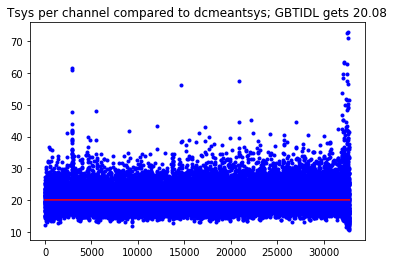

In [26]:
tsys1 = dcmeantsys(ton1,toff1,tcal1,mode=0)        # mode=0 does the mean before the division
tsys1m = tsys1v * 0.0 + tsys1
print("tsys from ON:",tsys1)
print("mode=0,1 should give 20.08 and 20.61")
plt.plot(chans,tsys1v,'b.')
plt.plot(chans,tsys1m,'r')
plt.title("Tsys per channel compared to dcmeantsys; GBTIDL gets 20.08");

This begs the question, what is the difference between taking the mean before or after the division. The difference is not large, see mode=0 and mode=1 above.

Look at the figure below, where we overplot the scaled difference on the raw spectrum: they follow each other nicely, which is comforting. Also recall, 10% is taken off the edges (which in this case does mean the galactic 
emission is *just* excluded from the averaging.

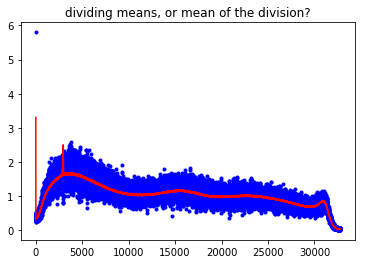

In [27]:
a=tsys1/tcal1
plt.plot(chans,(ton1-toff1)*a,'b.')
plt.plot(chans,toff1,'r')
#plt.xlim(2000,4000)
plt.title("dividing means, or mean of the division?");

The **dcmeantsys** procedure takes the mean 

now we repeat this for PROCSEQ=2, so records 44 and 45 for the calon/caloff 

TSYS from OFF: 19.29781949520111
This is normally the TSYS we use for calibration


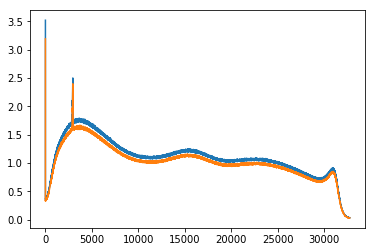

In [28]:
ton2  = spectra[44]
toff2 = spectra[45]
tcal2 = tcal[44]
plt.plot(chans,ton2)
plt.plot(chans,toff2)
#
tsys2 = dcmeantsys(ton2,toff2,tcal2)
print("TSYS from OFF:",tsys2)
print("This is normally the TSYS we use for calibration")

These values for **tsys** agree exactly with those that GBTIDL gets!

tsys from ON: 19.29781949520111
mode=0,1 should give 19.30 and 19.75 resp.


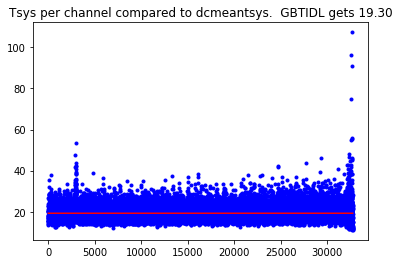

In [29]:
tsys2v = tcal2 * toff2 / (ton2 - toff2) + tcal2/2.0
tsys2  = dcmeantsys(ton2,toff2,tcal2,mode=0)        # mode=0 does the mean before the division
tsys2m = tsys2v * 0.0 + tsys2
print("tsys from ON:",tsys2)
print("mode=0,1 should give 19.30 and 19.75 resp.")
plt.plot(chans,tsys2v,'b.')
plt.plot(chans,tsys2m,'r')
plt.title("Tsys per channel compared to dcmeantsys.  GBTIDL gets 19.30");

19.29781949520111 20.075016379356384 19.29781949520111
ta      0.31241688 0.14541201 -0.28982547 0.88212734 6001
GBTIDL: 0.31242    0.14542    -0.28983    0.88213


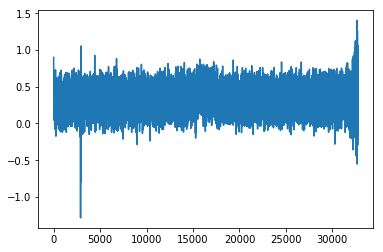

In [30]:
tsys = tsys2                 # the "OFF" tsys is used according to getps
print(tsys,tsys1,tsys2)
if True:
    # this is the math following eq.(2) on p5 of Braatz' 2009 calibration manual
    sig_calon = ton1
    sig_caloff = toff1
    ref_calon = ton2
    ref_caloff = toff2
    sig = 0.5*(sig_calon+sig_caloff)
    ref = 0.5*(ref_calon+ref_caloff)
    ta  = tsys * (sig-ref)/ref
else:
    # this was my assumed math, it matches GBTIDL not as well
    # but if you write out the math, this formula should be better
    ta1 = tsys * (toff1-toff2)/toff2  # 
    ta2 = tsys * (ton1-ton2)/ton2
    ta  = 0.5*(ta1+ta2)              # we used the /eqweight option in getps
    my_stats('ta1',ta1[6000:12001])
    my_stats('ta2',ta2[6000:12001])
plt.plot(chans,ta)
my_stats('ta    ',ta[6000:12001])
print("GBTIDL: 0.31242    0.14542    -0.28983    0.88213")

Possibly weighting differences? Even though we did use the **/eqweight** option.

In [31]:
#  save the spectrum for perhaps other work
from astropy.io import ascii
ascii.write([chans, ta], 'ngc5291_xx0.dat', names=['channel', 'Ta'], overwrite=True)

With some squinting, perhaps you can see the signal around channel 16000 ?  So lets do a big BoxCar smoothing and overlay it with the input signal:

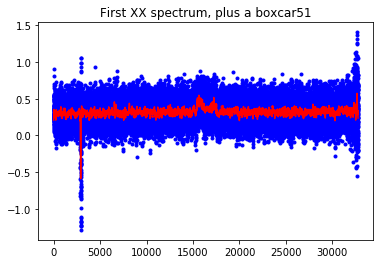

In [32]:
tabox = convolve(ta, Box1DKernel(51))
plt.plot(chans,ta,'b.')
plt.plot(chans,tabox,'r')
plt.title('First XX spectrum, plus a boxcar51');

One final thing remains: a more detailed comparison between IDL and this TOY work.The file **n5291_XX0.tab** contains the spectrum we obtained with **getps**, the first XX spectrum. Here we compare this with our toy version. Although we got the TSYS exactly, the individual data 

In [33]:
idltab = ascii.read('n5291_XX0.tab')
tidl=idltab['col2']

delta  6.002985118112214e-07 2.9759286822214417e-07 -2.5100326537241813e-06 2.633799743634313e-06 32768


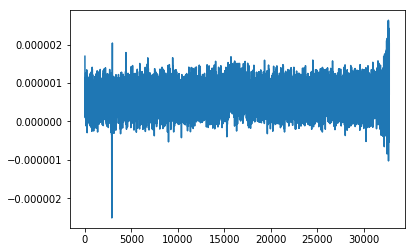

In [34]:
delta = tidl - ta
plt.plot(chans,delta)
my_stats('delta',delta);

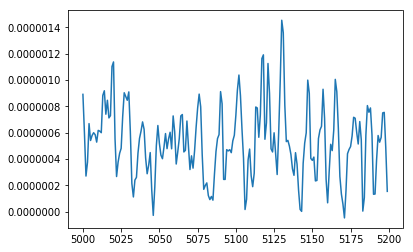

In [35]:
b=5000
e=b+200
plt.plot(chans[b:e],delta[b:e]);

Now repeat this for all spectra via the specially handcrafted worker2 function. After 88 spectra have been returned, we're going to average them.

Found 88 spectra4
ave  0.2953385877767869 0.015598872158571211 0.24291449267978102 0.3518439117099412 6001
ngc  0.375759715790529 0.04148872691243439 0.26010640393095935 0.5037464953281663 2500
CPU times: user 63.8 ms, sys: 3.55 ms, total: 67.3 ms
Wall time: 66.1 ms


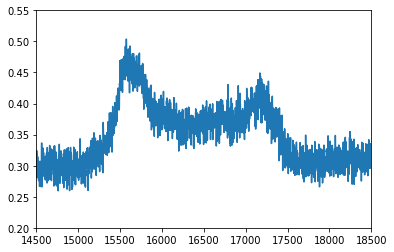

In [36]:
%%time
if src == 'NGC5291':
    (spectra4,tsys4) = my_worker2(spectra,tcal,nscan=4,mode=1)
    print("Found %d spectra4" % len(spectra4))

    ave = np.average(spectra4,axis=0)

    plt.plot(chans,ave)
    plt.xlim(14500,18500)
    plt.ylim(0.20,0.55)
    my_stats('ave',ave[6000:12001])
    my_stats('ngc',ave[15000:17500])

For NGC5291 we are supposed to get from stats:
    
    stats,6000,12000
     ; -> 0.29487  0.015592  0.24204   0.35086
     #    0.29889  0.015719  0.24665   0.35532  (old)
     #    0.29791  0.015734  0.24517   0.35472  (new)
        
so, not quite there yet. It is possibly that minute variations in EXPOSURE cause this?




For each spectrum we're going to compute the mean and rms in the line free region (6000:12000) and we'll notice that the RMS is fairly constant, but the XX and YY means are a little different. The histogram below also shows this clearly.

Mean and RMS of the RMS value: 0.14536175046269817 0.0029121028332147387
Min and Max in the MEAN value: 0.23532172744684854 0.34430116813665895


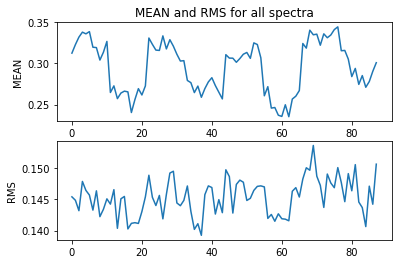

In [37]:
row4 = list(range(len(spectra4)))
m4 = np.zeros(len(spectra4))
r4 = np.zeros(len(spectra4))
dn4 = np.zeros(len(spectra4))
dx4 = np.zeros(len(spectra4))
for i in range(len(spectra4)):
    (m4[i],r4[i],dn4[i],dx4[i],n4) = my_stats("%d" % i, spectra4[i][6000:12001],verbose=False)
plt.subplot(212)
plt.plot(row4,r4)
plt.ylabel("RMS")
plt.subplot(211)
plt.plot(row4,m4)
plt.ylabel("MEAN")
plt.title('MEAN and RMS for all spectra')
print("Mean and RMS of the RMS value:",r4.mean(),r4.std())
print("Min and Max in the MEAN value:",m4.min(),m4.max())

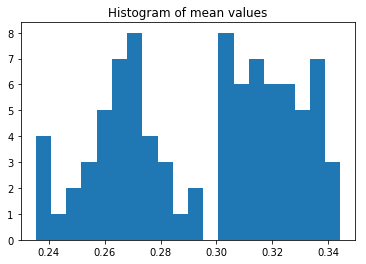

In [38]:
plt.hist(m4,20)
plt.title("Histogram of mean values");

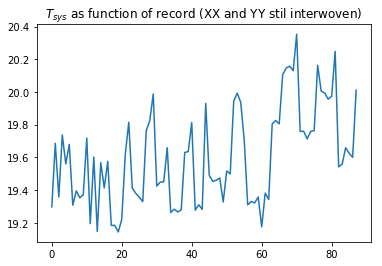

In [39]:
# plot tsys as function of time
row4 = list(range(len(tsys4)))
plt.plot(row4,tsys4)
#plt.plot(row4[1:176:2],tsys4[1:176:2])
plt.title("$T_{sys}$ as function of record (XX and YY stil interwoven)");

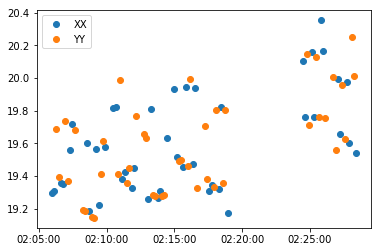

In [40]:

date_obs = data2[:]['DATE-OBS']  
dates = date_obs[0:352:4]
converted_dates = matplotlib.dates.datestr2num(dates)
if True:
    formatter = matplotlib.dates.DateFormatter('%H:%M:%S')
    fig,ax = plt.subplots()
    ax.xaxis.set_major_formatter(formatter)
#plt.plot_date(converted_dates, tsys4)
d1 = converted_dates[0:88:2]
t1 = tsys4[0:88:2]
d2 = converted_dates[1:88:2]
t2 = tsys4[1:88:2]
plt.plot_date(d1,t1,label='XX')
plt.plot_date(d2,t2,label='YY')
plt.legend();

ave2  0.2953364766332386 0.003929872051294175 0.2837708762451149 0.30728004133419445 6001
ave2  0.3645627253748899 0.04308772354469752 0.29336117698001807 0.4667481830517501 3000
In boxcar: S/N ~ (0.472-0.297)/0.00396= 44.19191919191919


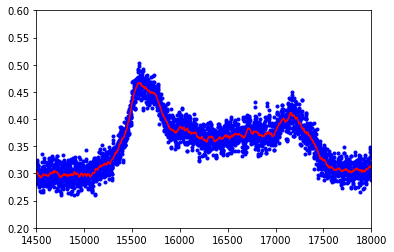

In [41]:
ave2 = convolve(ave, Box1DKernel(51))
plt.plot(chans,ave,'b.')
plt.plot(chans,ave2,'r')
plt.xlim(14500,18000)
plt.ylim(0.20,0.60);
my_stats('ave2',ave2[6000:12001])
my_stats('ave2',ave2[15000:18000])
print("In boxcar: S/N ~ (0.472-0.297)/0.00396=",(0.472-0.297)/0.00396)

### A few words on row organization

All the magic of how calibration is done is in the organization and labeling of the rows. For the **position switching** of the NGC5271 data we will see 352 rows organized in a 5D matrix as follows:

    DATA(cal,int,sampler,procseqn,scan)
          2   11    2        2      4
          
with the following notes:

* DATA is labeled in column-major ("fortran") order, i.e. the first listed dimension runs fastest
* 2 * 11 * 2 * 2 * 4 = 352
* each procseqn also increments the scan number, so there are really 8 scan values but only 4 in that dimension
* each sampler is taken at the same time, so this means after 22 rows (cal * int) , time repeats in the next 
  sampler (the XX and YY pol in this case)
* in this data samplers point to different polarizations, in argus samplers are the beams/feeds for a single XX polarization, so the SAMPLER slot in the data can be used for different means
* for this type of PS data, the procseqn defines the ON (1) and the OFF (2) position
* Depending on observing modes, the dimensionality of the DATA is different, e.g. for nod data at GBT we see
         DATA(cal, int, pol, sampler, procseqn, scan)
  

### How about Pandas DataFrame's ?

A pandas dataframe could contain the whole BINTABLE, and with an attached 'engine' reduce the rows in the waterfall plot to lower dimension (eventually 1 if it's a single pointing), which is the desired result. 
Compare this with operators such as **np.sum(axis=1)/nrow** if you just want to get an average spectrum.

In [ ]:
from astropy.table import Table
import pandas

t= Table.read(fname,format='fits') 
t.meta
df = t.to_pandas()

Thus, currently the astro Table cannot export to pandas.  If we do want it, we will do it manually, and with the modin replacement for pandas there could be a huge gain in operational speed if that becomes a bottleneck.

In [ ]:
import pandas as pd
#import modin.pandas as pd
# import xray

x = np.arange(0,10)
x2 = x.reshape(5,2)
y = np.sqrt(x)
point = {'x': x2,    'y' : y}
points = 10 * [point]

#
df = pd.DataFrame().append(points)
df.x[4]

# so in other words, bintable to panda's manually is ok, but not via the Table interface

### Adding astropy units to the X and Y axis

Specutils likes to work with things that have units. astropy to the rescue

In [ ]:
crval1 = data2[row]['CRVAL1']
cdelt1 = data2[row]['CDELT1']
crpix1 = data2[row]['CRPIX1']
freq0  = data2[row]['RESTFREQ']
freq = (crval1 + (np.arange(1,nchan+1) - crpix1) * cdelt1)/1e9
#
flux = flux * u.Unit("K")      # we're assuming, this was actually not in the header
freq = freq * u.Unit("GHz")    # or check CUNIT1 - usually not present in SDFITS files though

In [ ]:
# even though we've attached astropy units, they still work in matplotlib plotting
plt.plot(freq,flux)
plt.xlabel("Freq [%s]" % freq.unit)
plt.ylabel("Flux [%s]" % flux.unit);

### Creating a simple Spectrum1D object from specutils

In [ ]:
spec = Spectrum1D(spectral_axis=freq, flux=flux)

In [ ]:
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux);
# darn, the spectral axis still has 1e9 units, and it doesn't identify the units

## Designing our own reader in specutils

The specutils manual explains how to make your own reader. At the moment of writing there is no "sdfits" reader, so we're making a simple example with just a few meta-data. But this will simplify working with specutils.

There will be some issue w.r.t. SDFITS dialects. So we may have to write a GBT specific loader.

In [ ]:
loaders = get_loaders_by_extension('fits')
print(loaders)

We need a list of FITS keywords and FIELD names from the BINTABLE that are going to be the meta-data
associated with each spectrum. For now, just a few very important ones, but the list is large for full processing. 


In [ ]:
# just a few important ones for now, there are about 70 in the full SDFITS

sdfits_headers = ['SCAN', 'PROCSEQN', 'CAL', 'OBJECT','SAMPLER', 'TCAL']

We are registering a special fits reader for the spectra, and use a SpectrumList.


In [ ]:
def identify_sdfits(origin, *args, **kwargs):
    print("IDENTIFY_SDFITS")
    try:
        with fits.open(args[0]) as hdulist:
            extname = hdulist[1].header['EXTNAME']
            if extname == 'SINGLE DISH':
                print("Hurray, we have SDFITS")
                return True
            else:
                print("Warning, skipping extname %s" % extname)
                return False
    except Exception:
        return Falseflux + sl2[i].flux

    

In [ ]:
@data_loader("sdfits", identifier=identify_sdfits, dtype=SpectrumList, extensions=['fits'])
def sdfits_loader(file_name, spectral_axis_unit=None, **kwargs):

    spectra = []
    with fits.open(file_name, **kwargs) as hdulist:
        header1= hdulist[0].header        
        header2= hdulist[1].header
        data   = hdulist[1].data
        nrow   = len(data)
        nchan  = 0
        for i in range(nrow):
            sp = data[i]['DATA']
            if nchan==0:
                nchan = len(sp)     # every spectrum in SDFITS has the same length
            crval1  = data[i]['CRVAL1']
            cdelt1  = data[i]['CDELT1']
            crpix1  = data[i]['CRPIX1']
            ctype1  = data[i]['CTYPE1']     # 'FREQ-OBS' to 'FREQ'; assuming SPECSYS='TOPOCENT'
            restfrq = data[i]['RESTFREQ']
            cunit1  = 'Hz'
            crval2  = data[i]['CRVAL2']
            crval3  = data[i]['CRVAL3']
            ctype2  = data[i]['CTYPE2']
            ctype3  = data[i]['CTYPE3']
            if ctype1 == 'FREQ-OBS': ctype1  = 'FREQ'
            # only axis1 needs a full description, axis2,3,4 are all single points
            wcs = WCS(header={'CDELT1': cdelt1, 'CRVAL1': crval1, 'CUNIT1': cunit1,
                              'CTYPE1': ctype1, 'CRPIX1': crpix1, 'RESTFRQ': restfrq,
                              'CTYPE2': ctype2, 'CRVAL2': crval2,
                              'CTYPE3': ctype3, 'CRVAL3': crval3})
                              

            meta = {}
            if False:
                # adding the actual FITS headers is for debugging, but not in production mode
                meta['header1'] = header1
                meta['header2'] = header2
            if True:
                for key in sdfits_headers:
                    if key in header1:
                        meta[key] = header1[key]
                    elif key in header2:
                        meta[key] = header2[key]
                    else:
                        meta[key] = data[i][key]    # why doesn't       key in data[i]    work?
                # add our row counter
                meta['_row'] = i
                        
        
            sp = sp * Unit('K')
            spec = Spectrum1D(flux=sp, wcs=wcs, meta=meta, velocity_convention="radio")
            spectra.append(spec)
            
    return  SpectrumList(spectra)

Now we are ready for some action! But lets define a small spectrum plotter with some nicer units



In [ ]:
%%time
# 3004 spectra in 7.5sec  
# 352 spectra in 931ms for ex1)
sl1 = SpectrumList.read(fname, format="sdfits")
nsp = len(sl1)
print("Found %d spectra" % nsp)

In [ ]:
sp=sl1[0]
#sp.velocity("km/s",type="doppler_radio")
#sp.velocity_convention
sp.velocity
sp.spectral_axis
my_plot(sp,True)
sp.velocity
#plt.plot(sp.velocity,sp.flux)
sp

In [ ]:
%%time
gbt1 = my_loader1(fname)
print("Found %d spectra" % len(gbt1['spectra']))
#   this is a raw SDFITS loader,for comparison

In [ ]:
print("Here are the first two spectra, the CalOn and CalOff")
for i in range(2):
    my_stats("spec    ",sl1[i].flux.value)
    my_stats("bintable",spectra[i])

In [ ]:
sp  = sl1[0]
x=sp.spectral_axis/(1 * Unit("Hz"))/1e6
y=sp.flux
type(y)
print(y.unit)


In [ ]:
# here is an issue:    cannot combine the ON and OFF for example if taken on different times

a=sl1[0]-sl1[1]
b=sl1[2]-sl1[3]
print(a)
print(b)
try:
    c = a + b
except:
    print("*** Cannot combine ***")
a1 = a / sl1[0]
print(a1)
# cannot do a+b, spectral axis is TOPO
# does this imply that if our ephemeris isn't good enough, they will not align in doppler space
# and thus refuse to be combined?

In [ ]:
# lets look at the meta data where we know there are changes
# there are 8 scans of 11 integrations each, two polarizations and the on/off cal cycle
for i in [0,1,22,44,88]:
    print(i,sl1[i].meta)


In [ ]:
%%time 
# 7.5s  (1.0s for ex1)
# this is like my_worker1() presented earlier
Spectra = []
for i in range(0,nsp,2):
    sp1 = sl1[i]      # this is the ON in PROCSEQN=1     
    sp2 = sl1[i+1]
    tsys = sl1[i].meta['TCAL']
    sp = (sp1-sp2)/sp2.flux.value * tsys     # don't use the units.....       
    sp.meta = sp1.meta
    #sp.flux *= tsys           # this is silly, can't modify the flux.....
    Spectra.append(sp)
    
sl2 =  SpectrumList(Spectra)   

Take the first calibrated spectrum, and see how it compares ith GBTIDL

In [ ]:
# GBTIDL:  getps,51,intnum=0  &  stats,/full
# 0.27865 0.16342 -1.5897 1.8587
my_stats("first R:",sl2[0].flux)
#my_plot(sl2[0])
plt.plot(chans,sl2[0].flux)
print(len(sl2))

In [ ]:
print(sp)
a = sp * 2
print(a)
a=sp.multiply(2*u.Unit('mJy'))   
print(sp)
print(a)
a = a * (2*u.Unit('mJy'))
print(a)


In [ ]:
for i in [0,1,11,22]:
    print(i,sl2[i].meta)

In [ ]:
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
print(sp
    )
spec1 = Spectrum1D(flux=ave*u.Unit("K"), wcs=sp.wcs, meta=sp.meta)
spec1_bsmooth = box_smooth(spec1, width=3)
spec1_gsmooth = gaussian_smooth(spec1, stddev=3)
spec1_tsmooth = trapezoid_smooth(spec1, width=3)

In [ ]:
plt.plot(chans, spec1.flux) 
plt.xlim(14500,18000)
plt.ylim(0.2,0.6)

In [ ]:
plt.plot(chans, spec1_bsmooth.flux) 
plt.title("Boxcar Smooth")
plt.xlim(14500,18000)
plt.ylim(0.2,0.6)

In [ ]:
plt.plot(chans, spec1_gsmooth.flux)
plt.title("Gaussian Smooth")
plt.xlim(14500,18000)
plt.ylim(0.2,0.6)

In [ ]:
plt.plot(chans, spec1_tsmooth.flux) 
plt.title("Trapezoid Smooth")
plt.xlim(14500,18000)
plt.ylim(0.2,0.6)